# Importações

In [1]:
import io
import zipfile
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Consumindo bases

In [2]:
url_sensor = "https://github.com/AILAB-CEFET-RJ/qualiar/raw/main/NEW_TEST/Data/Sensores/sensores.zip"

response = requests.get(url_sensor)
response.raise_for_status()

zip_file = zipfile.ZipFile(io.BytesIO(response.content))

print("Arquivos no ZIP:")
print(zip_file.namelist())

with zip_file.open(zip_file.namelist()[0]) as file:
    df_sensor = pd.read_csv(file)  

df_sensor.head()

Arquivos no ZIP:
['sensores.csv']


,objectid,data,codnum,estação,chuva,pres,rs,temp,ur,dir_vento,...,co,no,nox,o3,pm10,pm2_5,lat,lon,x_utm_sirgas2000,y_utm_sirgas2000
0,2372436,1/1/2011 6:30:00 AM,3,CA,0.2,1009.33,1.57,21.81,84.50,250.67,...,0.17,NaN,NaN,17.89,10.0,NaN,-22.908344,-43.178152,686853.7075,7.465470e+06
1,2372437,1/1/2011 7:30:00 AM,3,CA,0.0,1009.00,1.40,21.79,84.73,121.17,...,0.21,NaN,NaN,12.44,11.0,NaN,-22.908344,-43.178152,686853.7075,7.465470e+06
2,2372438,1/1/2011 8:30:00 AM,3,CA,0.2,1008.17,1.37,21.44,85.70,85.67,...,0.17,NaN,NaN,18.97,38.0,NaN,-22.908344,-43.178152,686853.7075,7.465470e+06
3,2372439,1/1/2011 9:30:00 AM,3,CA,0.0,1008.00,1.30,21.17,88.57,85.33,...,0.22,NaN,NaN,11.08,8.0,NaN,-22.908344,-43.178152,686853.7075,7.465470e+06
4,2372440,1/1/2011 10:30:00 AM,3,CA,0.2,1008.00,1.32,21.25,89.28,73.00,...,0.22,NaN,NaN,11.28,10.0,NaN,-22.908344,-43.178152,686853.7075,7.465470e+06


In [3]:
url_estacoes = 'https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/NEW_TEST/Data/Sensores/estacoes.csv'

df_estacoes = pd.read_csv(url_estacoes, sep=',')

url_qualidade_ar = 'https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/NEW_TEST/Data/Sensores/ind_qual_ar_17_24.csv'

df_qualidade_ar = pd.read_csv(url_qualidade_ar, sep=',')

# Pré-processamento

## Selecionando e criando colunas

In [4]:
#@title Criando coluna nome estacao com base na coluna codnum
df_sensor['nome_estacao'] = df_sensor['codnum'].map(df_estacoes.set_index('codnum')['nome'])

In [5]:
#@title Selecionando as colunas mais relevantes
interest_columns = ['nome_estacao', 'data', 'chuva', 'temp', 'ur', 'co', 'no', 'no2', 'nox', 'so2', 'o3', 'pm10', 'pm2_5', 'lat', 'lon']

df_sensor_interest = df_sensor[interest_columns]

In [6]:
#@title Criando colunas de ano e mês para facilitar a análise temporal
df_sensor_interest['data'] = pd.to_datetime(df_sensor_interest['data'], format='%m/%d/%Y %I:%M:%S %p')
df_sensor_interest['data_formatada'] = pd.to_datetime(df_sensor_interest['data']).dt.strftime('%Y-%m-%d')
df_sensor_interest['ano'] = df_sensor_interest['data'].dt.year
df_sensor_interest['mes'] = df_sensor_interest['data'].dt.month

C:\Users\jhter\AppData\Local\Temp\ipykernel_29732\1024544581.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_interest['data'] = pd.to_datetime(df_sensor_interest['data'], format='%m/%d/%Y %I:%M:%S %p')
C:\Users\jhter\AppData\Local\Temp\ipykernel_29732\1024544581.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_interest['data_formatada'] = pd.to_datetime(df_sensor_interest['data']).dt.strftime('%Y-%m-%d')
C:\Users\jhter\AppData\Local\Temp\ipykernel_29732\1024544581.py:4: SettingWit

In [7]:
#@title Removendo ano de 2011 (Pela falta de alguns poluente) e anos da pandemia
df_sensor_interest_filtered = df_sensor_interest[df_sensor_interest['ano'] > 2011]

In [8]:
#@title Filtrando por Irajá
df_sensor_iraja = df_sensor_interest_filtered[df_sensor_interest_filtered['nome_estacao'] == 'ESTAÇÃO IRAJÁ']

In [9]:
df_qualidade_ar['data_formatada'] = pd.to_datetime(df_qualidade_ar['data']).dt.strftime('%Y-%m-%d')
df_qualidade_ar_iraja = df_qualidade_ar[df_qualidade_ar['estacao_nome'] == 'Irajá']

# Tratando colunas de interesse por Estação de monitoriamento


## Estação Irajá
Colunas normalizadas: Chuva, Temperatura, Umidade relativa, CO, NO, NO2, NOx, SO2, O3, PM10, PM2.5

### Chuva

In [10]:
df_sensor_iraja['chuva'].describe()

count    110950.000000
mean          0.201466
std           3.507672
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         163.500000
Name: chuva, dtype: float64

In [11]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['chuva'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 3026


In [12]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['chuva_nulos_no_dia'] = (
    df_sensor_iraja['chuva'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-12-1153404511.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['chuva_nulos_no_dia'] = (


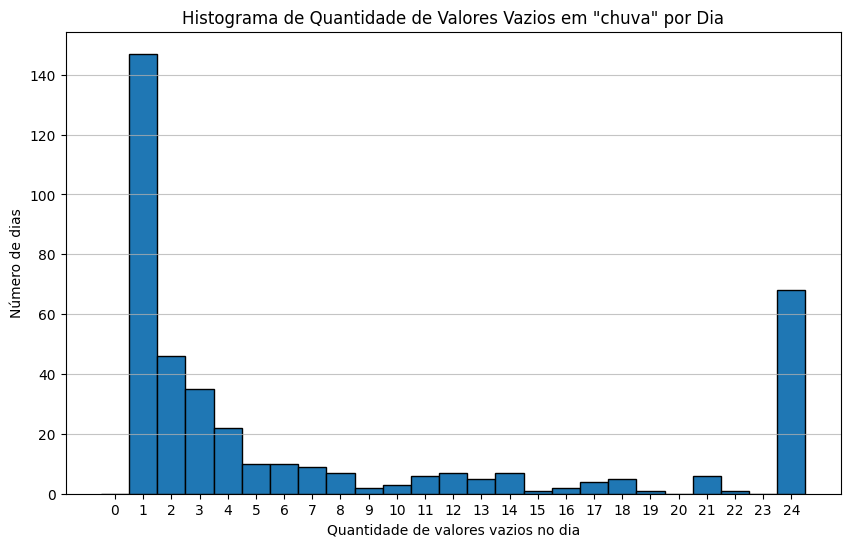

In [13]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['chuva_nulos_no_dia'] != 0].groupby('data_formatada')['chuva_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "chuva" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [14]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias)

mask = (df_sensor_iraja['chuva_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['chuva'].isnull().sum()
df_sensor_iraja.loc[mask, 'chuva'] = df_sensor_iraja[mask]['chuva'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'chuva'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

542 linhas foram preenchidas com interpolate na coluna 'chuva'.
Foram preenchido 18% de dados


In [15]:
df_sensor_iraja['chuva'].describe()

,chuva
count,111492.000000
mean,0.202630
std,3.502874
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,163.500000


### Temperatura

In [16]:
df_sensor_iraja['temp'].describe()

,temp
count,87587.000000
mean,27.113502
std,5.063265
min,6.220000
25%,23.530000
50%,26.530000
75%,30.170000
max,46.380000


In [17]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['temp'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 26389


In [18]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['temp_nulos_no_dia'] = (
    df_sensor_iraja['temp'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-18-2731076536.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['temp_nulos_no_dia'] = (


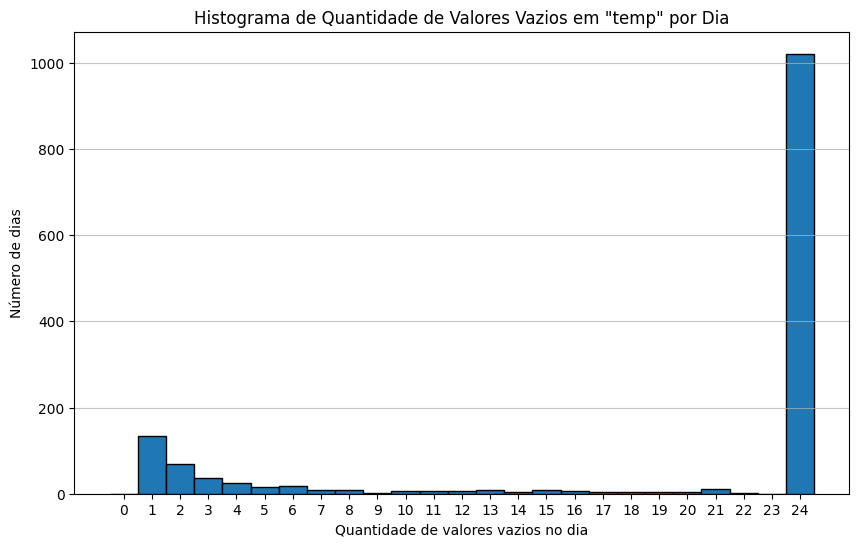

In [19]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['temp_nulos_no_dia'] != 0].groupby('data_formatada')['temp_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "temp" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [20]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_iraja['temp_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['temp'].isnull().sum()
df_sensor_iraja.loc[mask, 'temp'] = df_sensor_iraja[mask]['temp'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'temp'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

666 linhas foram preenchidas com interpolate na coluna 'temp'.
Foram preenchido 3% de dados


In [21]:
df_sensor_iraja['temp'].describe()

,temp
count,88253.000000
mean,27.125839
std,5.063816
min,6.220000
25%,23.550000
50%,26.550000
75%,30.200000
max,46.380000


### Umidade relativa

In [22]:
df_sensor_iraja['ur'].describe()

,ur
count,81052.000000
mean,69.470876
std,19.581888
min,0.000000
25%,55.100000
50%,70.950000
75%,84.780000
max,100.000000


In [23]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['ur'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 32924


In [24]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['ur_nulos_no_dia'] = (
    df_sensor_iraja['ur'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-24-1337548978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['ur_nulos_no_dia'] = (


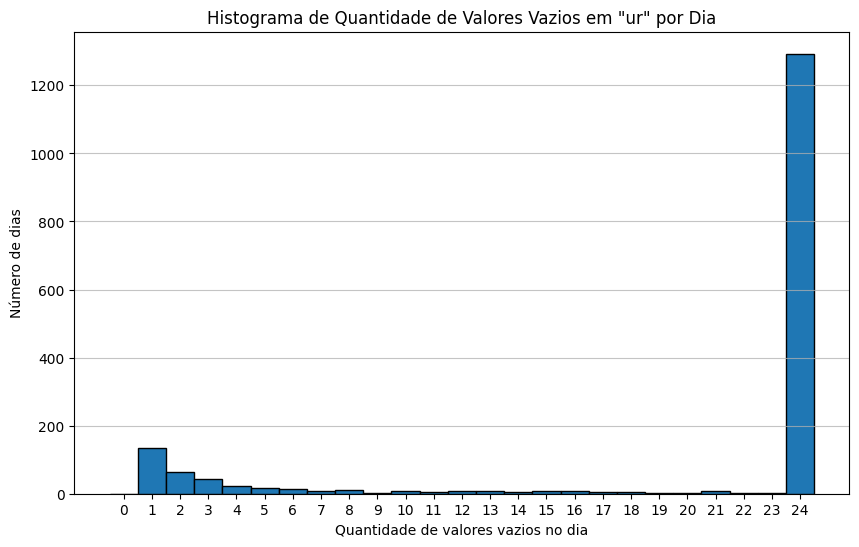

In [25]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['ur_nulos_no_dia'] != 0].groupby('data_formatada')['ur_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "ur" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [26]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_iraja['ur_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['ur'].isnull().sum()
df_sensor_iraja.loc[mask, 'ur'] = df_sensor_iraja[mask]['ur'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'ur'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

667 linhas foram preenchidas com interpolate na coluna 'ur'.
Foram preenchido 2% de dados


In [27]:
df_sensor_iraja['ur'].describe()

,ur
count,81719.000000
mean,69.437507
std,19.584741
min,0.000000
25%,55.030000
50%,70.880000
75%,84.770000
max,100.000000


### Monóxido de carbono

In [28]:
df_sensor_iraja['co'].describe()

,co
count,98152.000000
mean,0.454012
std,0.295796
min,0.000000
25%,0.280000
50%,0.390000
75%,0.550000
max,4.620000


In [29]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['co'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 15824


In [30]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['co_nulos_no_dia'] = (
    df_sensor_iraja['co'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-30-2772747785.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['co_nulos_no_dia'] = (


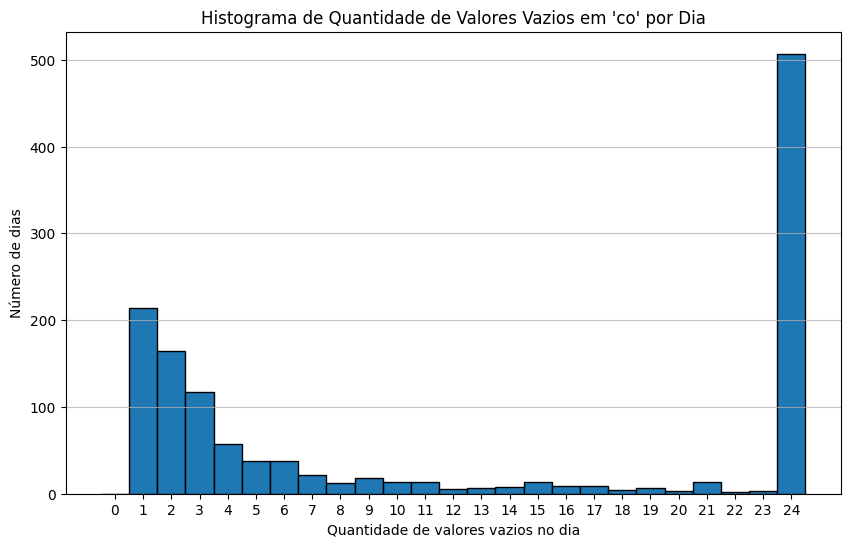

In [31]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['co_nulos_no_dia'] != 0].groupby('data_formatada')['co_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'co' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [32]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_iraja['co_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['co'].isnull().sum()
df_sensor_iraja.loc[mask, 'co'] = df_sensor_iraja[mask]['co'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'co'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

1539 linhas foram preenchidas com interpolate na coluna 'co'.
Foram preenchido 10% de dados


In [33]:
df_sensor_iraja['co'].describe()

,co
count,99691.000000
mean,0.453874
std,0.295622
min,0.000000
25%,0.280000
50%,0.390000
75%,0.550000
max,4.620000


### Monóxido de Nitrogênio

In [34]:
df_sensor_iraja['no'].describe()

,no
count,103430.000000
mean,17.276016
std,32.539058
min,0.000000
25%,3.040000
50%,6.660000
75%,16.340000
max,640.380000


In [35]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['no'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 10546


In [36]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['no_nulos_no_dia'] = (
    df_sensor_iraja['no'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-36-2473781293.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['no_nulos_no_dia'] = (


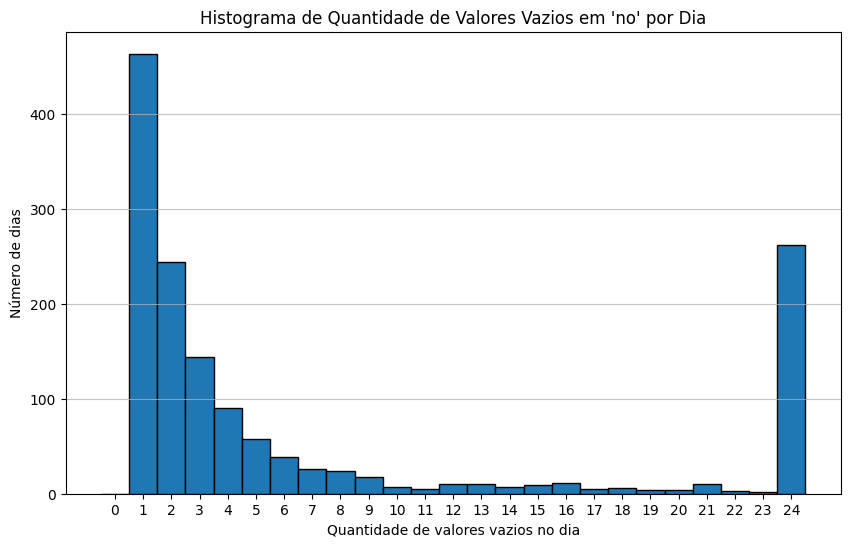

In [37]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['no_nulos_no_dia'] != 0].groupby('data_formatada')['no_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'no' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [38]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_iraja['no_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['no'].isnull().sum()
df_sensor_iraja.loc[mask, 'no'] = df_sensor_iraja[mask]['no'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'no'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

2267 linhas foram preenchidas com interpolate na coluna 'no'.
Foram preenchido 21% de dados


In [39]:
df_sensor_iraja['no'].describe()

,no
count,105697.000000
mean,17.189971
std,32.459617
min,0.000000
25%,3.010000
50%,6.620000
75%,16.230000
max,640.380000


### Dióxido de Nitrogênio

In [40]:
df_sensor_iraja['no2'].describe()

,no2
count,103492.000000
mean,38.250203
std,20.422660
min,0.000000
25%,23.597500
50%,34.660000
75%,48.720000
max,211.810000


In [41]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['no2'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 10484


In [42]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['no2_nulos_no_dia'] = (
    df_sensor_iraja['no2'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-42-726802487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['no2_nulos_no_dia'] = (


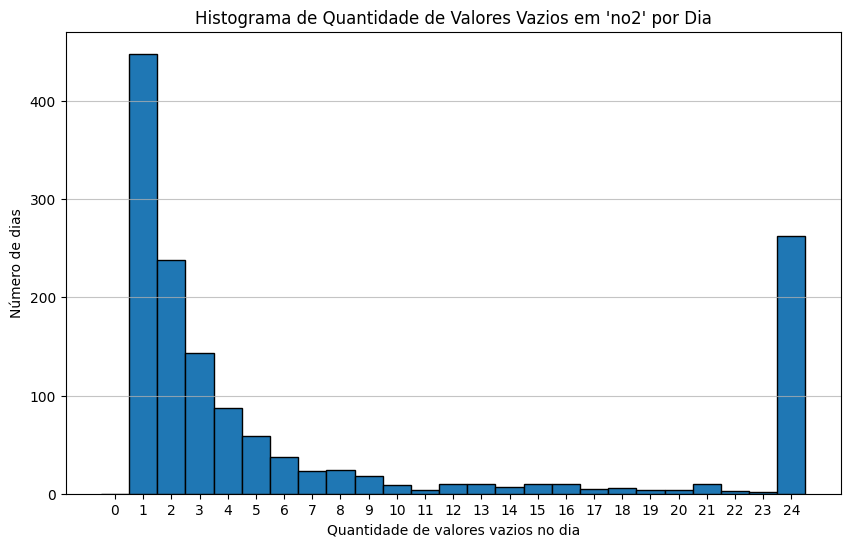

In [43]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['no2_nulos_no_dia'] != 0].groupby('data_formatada')['no2_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'no2' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [44]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_iraja['no2_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['no2'].isnull().sum()
df_sensor_iraja.loc[mask, 'no2'] = df_sensor_iraja[mask]['no2'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'no2'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

2218 linhas foram preenchidas com interpolate na coluna 'no2'.
Foram preenchido 21% de dados


In [45]:
df_sensor_iraja['no2'].describe()

,no2
count,105710.000000
mean,38.185275
std,20.434979
min,0.000000
25%,23.530000
50%,34.590000
75%,48.650000
max,211.810000


### Óxido de Nitrogênio

In [46]:
df_sensor_iraja['nox'].describe()

,nox
count,103488.000000
mean,55.531865
std,45.720682
min,0.000000
25%,28.210000
50%,42.825000
75%,67.000000
max,702.670000


In [47]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['nox'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 10488


In [48]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['nox_nulos_no_dia'] = (
    df_sensor_iraja['nox'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-48-2916221577.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['nox_nulos_no_dia'] = (


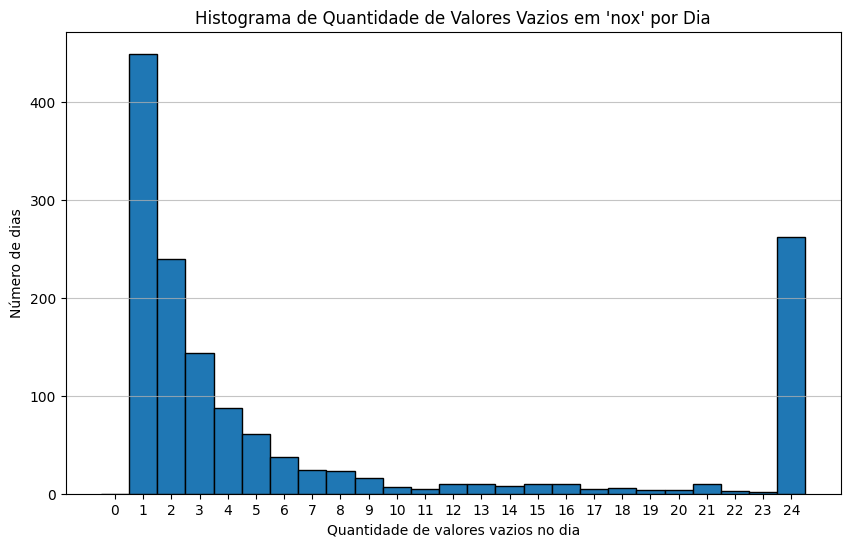

In [49]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['nox_nulos_no_dia'] != 0].groupby('data_formatada')['nox_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'nox' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [50]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_iraja['nox_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['nox'].isnull().sum()
df_sensor_iraja.loc[mask, 'nox'] = df_sensor_iraja[mask]['nox'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'nox'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

2236 linhas foram preenchidas com interpolate na coluna 'nox'.
Foram preenchido 21% de dados


In [51]:
df_sensor_iraja['nox'].describe()

,nox
count,105724.000000
mean,55.389989
std,45.654787
min,0.000000
25%,28.100000
50%,42.710000
75%,66.860000
max,702.670000


### Dióxido de Enxofre

In [52]:
df_sensor_iraja['so2'].describe()

,so2
count,73748.000000
mean,4.539614
std,6.580275
min,0.000000
25%,0.880000
50%,3.130000
75%,6.020000
max,309.130000


In [53]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['so2'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 40228


In [54]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['so2_nulos_no_dia'] = (
    df_sensor_iraja['so2'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-54-2857888169.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['so2_nulos_no_dia'] = (


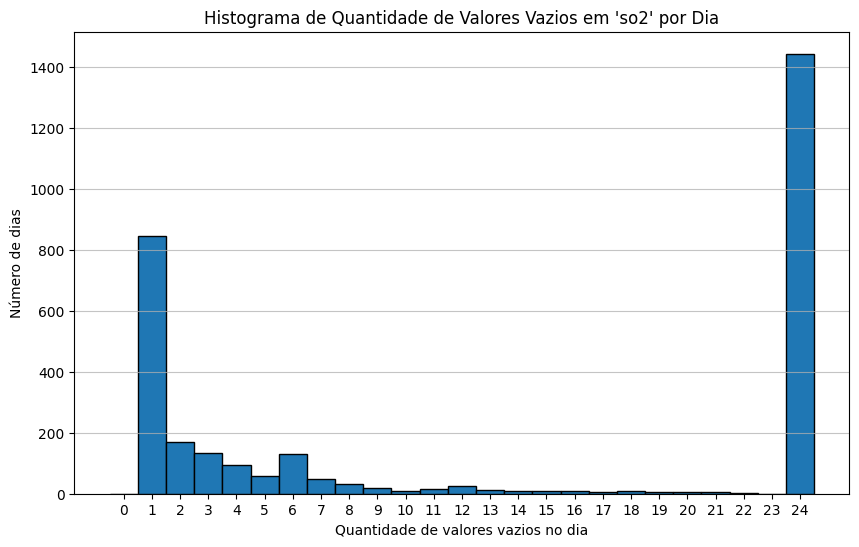

In [55]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['so2_nulos_no_dia'] != 0].groupby('data_formatada')['so2_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'so2' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [56]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_iraja['so2_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['so2'].isnull().sum()
df_sensor_iraja.loc[mask, 'so2'] = df_sensor_iraja[mask]['so2'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'so2'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

3031 linhas foram preenchidas com interpolate na coluna 'so2'.
Foram preenchido 8% de dados


In [57]:
df_sensor_iraja['so2'].describe()

,so2
count,76779.000000
mean,4.535962
std,6.545593
min,0.000000
25%,0.890000
50%,3.130000
75%,6.010000
max,309.130000


### Ozônio

In [58]:
df_sensor_iraja['o3'].describe()

,o3
count,100607.000000
mean,35.657054
std,33.302753
min,0.000000
25%,10.280000
50%,27.360000
75%,50.680000
max,355.450000


In [59]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['o3'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 13369


In [60]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['o3_nulos_no_dia'] = (
    df_sensor_iraja['o3'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-60-1905008294.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['o3_nulos_no_dia'] = (


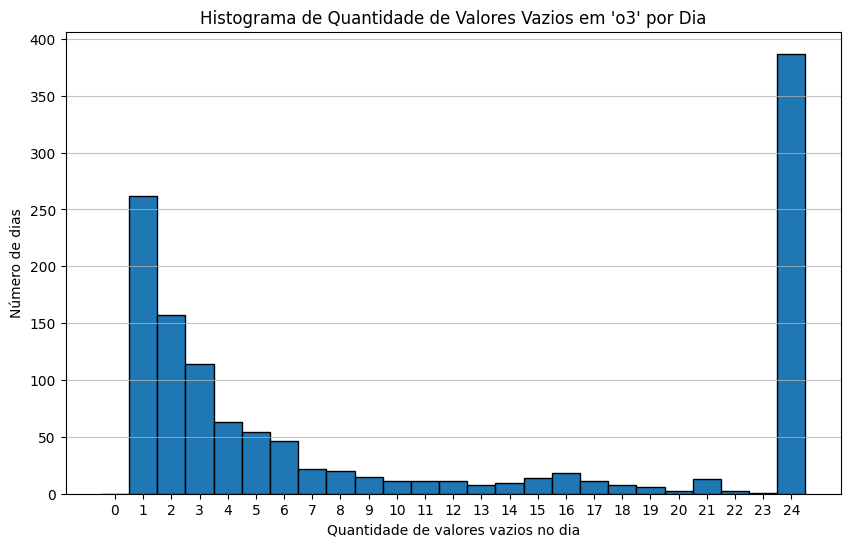

In [61]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['o3_nulos_no_dia'] != 0].groupby('data_formatada')['o3_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'o3' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [62]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_iraja['o3_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['o3'].isnull().sum()
df_sensor_iraja.loc[mask, 'o3'] = df_sensor_iraja[mask]['o3'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'o3'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

1716 linhas foram preenchidas com interpolate na coluna 'o3'.
Foram preenchido 13% de dados


In [63]:
df_sensor_iraja['o3'].describe()

,o3
count,102323.000000
mean,35.666162
std,33.269002
min,0.000000
25%,10.280000
50%,27.410000
75%,50.710000
max,355.450000


### PM10

In [64]:
df_sensor_iraja['pm10'].describe()

,pm10
count,107302.000000
mean,35.841466
std,23.379124
min,0.000000
25%,20.000000
50%,31.000000
75%,45.000000
max,409.000000


In [65]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['pm10'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 6674


In [66]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['pm10_nulos_no_dia'] = (
    df_sensor_iraja['pm10'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-66-3776899338.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['pm10_nulos_no_dia'] = (


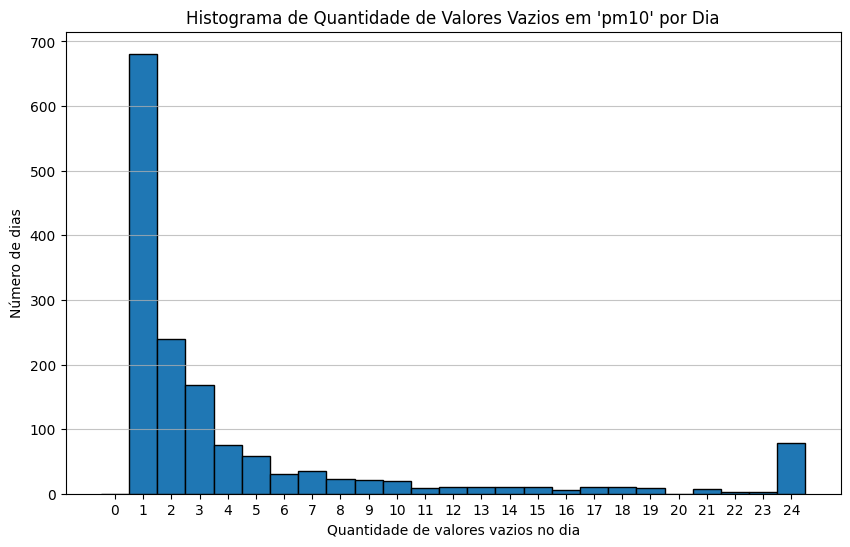

In [67]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['pm10_nulos_no_dia'] != 0].groupby('data_formatada')['pm10_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'pm10' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [68]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_iraja['pm10_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['pm10'].isnull().sum()
df_sensor_iraja.loc[mask, 'pm10'] = df_sensor_iraja[mask]['pm10'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'pm10'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

2439 linhas foram preenchidas com interpolate na coluna 'pm10'.
Foram preenchido 37% de dados


In [69]:
df_sensor_iraja['pm10'].describe()

,pm10
count,109741.000000
mean,35.775685
std,23.396910
min,0.000000
25%,20.000000
50%,31.000000
75%,45.000000
max,409.000000


### PM2.5

In [70]:
df_sensor_iraja['pm2_5'].describe()

,pm2_5
count,95733.000000
mean,16.522923
std,14.415199
min,0.000000
25%,7.000000
50%,13.000000
75%,22.000000
max,370.000000


In [71]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_iraja[df_sensor_iraja['pm2_5'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 18243


In [72]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_iraja['pm2_5_nulos_no_dia'] = (
    df_sensor_iraja['pm2_5'].isnull()
    .groupby(df_sensor_iraja['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-72-3039291287.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja['pm2_5_nulos_no_dia'] = (


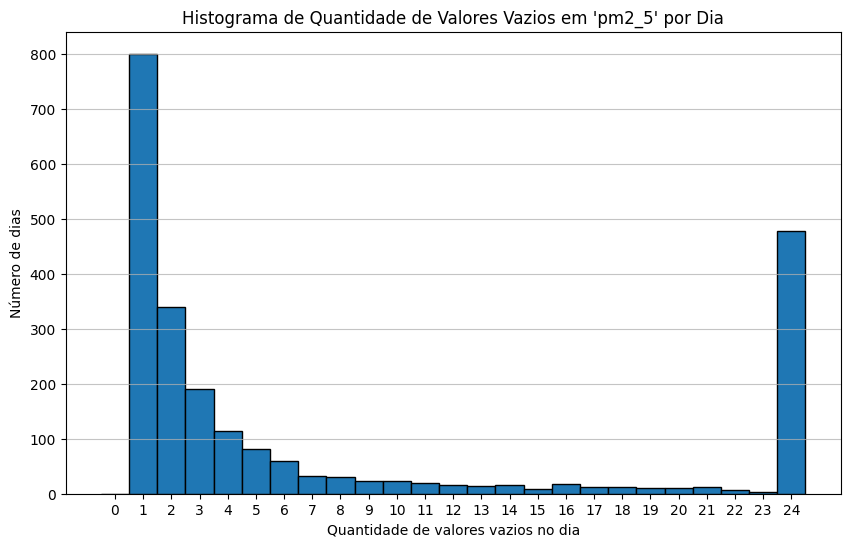

In [73]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_iraja[df_sensor_iraja['pm2_5_nulos_no_dia'] != 0].groupby('data_formatada')['pm2_5_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'pm2_5' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [74]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_iraja['pm2_5_nulos_no_dia'] <= 6)

num_nulls = df_sensor_iraja[mask]['pm2_5'].isnull().sum()
df_sensor_iraja.loc[mask, 'pm2_5'] = df_sensor_iraja[mask]['pm2_5'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'pm2_5'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

3284 linhas foram preenchidas com interpolate na coluna 'pm2_5'.
Foram preenchido 18% de dados


In [75]:
df_sensor_iraja['pm2_5'].describe()

,pm2_5
count,99017.000000
mean,16.510114
std,14.385772
min,0.000000
25%,7.000000
50%,13.000000
75%,22.000000
max,370.000000


In [76]:
droping_columns = ['nome_estacao', 'chuva_nulos_no_dia', 'temp_nulos_no_dia', 'ur_nulos_no_dia', 'co_nulos_no_dia', 'no_nulos_no_dia', 'no2_nulos_no_dia', 'nox_nulos_no_dia', 'so2_nulos_no_dia', 'o3_nulos_no_dia', 'pm10_nulos_no_dia', 'pm2_5_nulos_no_dia']

df_sensor_iraja.drop(columns=droping_columns, inplace=True)

/tmp/ipython-input-76-1752678507.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_iraja.drop(columns=droping_columns, inplace=True)


# Criando nova feature (AQI)

| MP₁₀ (µg/m³) 24h | MP₂.₅ (µg/m³) 24h | O₃ (µg/m³) 8h | CO (ppm) 8h | NO₂ (µg/m³) 1h | SO₂ (µg/m³) 24h | Índice | Qualidade do Ar | Efeitos |
|------------------|------------------|---------------|-------------|----------------|------------------|--------|------------------|---------|
| 0 - 50           | 0 - 25           | 0 - 100       | 0 - 9       | 0 - 200        | 0 - 20           | 0 - 40 | N1 - Boa         | - |
| >50 - 100        | >25 - 50         | >100 - 130    | >9 - 11     | >200 - 240     | >20 - 40         | 41 - 80 | N2 - Moderada     | Pessoas de grupos sensíveis (crianças, idosos e pessoas com doenças respiratórias e cardíacas) podem apresentar sintomas como tosse seca e cansaço. A população em geral não é afetada. |
| >100 - 150       | >50 - 75         | >130 - 160    | >11 - 13    | >240 - 320     | >40 - 365        | 81 - 120 | N3 - Ruim         | Toda a população pode apresentar sintomas como tosse seca, cansaço, ardor nos olhos, nariz e garganta. Pessoas de grupos sensíveis (crianças, idosos e pessoas com doenças respiratórias e cardíacas) podem apresentar efeitos mais sérios na saúde. |
| >150 - 250       | >75 - 125        | >160 - 200    | >13 - 15    | >320 - 1130    | >365 - 800       | 121 - 200 | N4 - Muito Ruim   | Toda a população pode apresentar agravamento dos sintomas como tosse seca, cansaço, ardor nos olhos, nariz e garganta e ainda falta de ar e respiração ofegante. Efeitos ainda mais graves à saúde de grupos sensíveis (crianças, idosos e pessoas com doenças respiratórias e cardíacas). |
| >250 - 600       | >125 - 300       | >200 - 800    | >15 - 50    | >1130 - 3750   | >800 - 2620      | 201 - 400 | N5 - Péssima      | Toda a população pode apresentar sérios riscos de manifestações de doenças respiratórias e cardiovasculares. Aumento de mortes prematuras em pessoas de grupos sensíveis. |


In [77]:
# Carrega o DataFrame
df = df_sensor_iraja.copy()

# Converte e ordena
df['data'] = pd.to_datetime(df['data'])
df = df.sort_values(by='data')

In [78]:
# Define faixas com interpolação linear (c_low, c_high, i_low, i_high)
faixas_aqi = {
    'pm10':   [(0, 50, 0, 40), (50, 100, 41, 80), (100, 150, 81, 120), (150, 250, 121, 200), (250, 600, 201, 400)],
    'pm2_5':  [(0, 25, 0, 40), (25, 50, 41, 80), (50, 75, 81, 120), (75, 125, 121, 200), (125, 300, 201, 400)],
    'o3':     [(0, 100, 0, 40), (100, 130, 41, 80), (130, 160, 81, 120), (160, 200, 121, 200), (200, 800, 201, 400)],
    'co':     [(0, 9, 0, 40), (9, 11, 41, 80), (11, 13, 81, 120), (13, 15, 121, 200), (15, 50, 201, 400)],
    'no2':    [(0, 200, 0, 40), (200, 240, 41, 80), (240, 320, 81, 120), (320, 1130, 121, 200), (1130, 3750, 201, 400)],
    'so2':    [(0, 20, 0, 40), (20, 40, 41, 80), (40, 365, 81, 120), (365, 800, 121, 200), (800, 2620, 201, 400)],
}

In [79]:
# Função de interpolação para cálculo contínuo do AQI
def calcular_aqi(valor, faixas):
    for c_low, c_high, i_low, i_high in faixas:
        if c_low <= valor <= c_high:
            return ((i_high - i_low) / (c_high - c_low)) * (valor - c_low) + i_low
    return np.nan  # Fora das faixas

In [80]:
# Função para média 8h móvel diária (máxima por dia)
def media_8h_movel(df, col):
    resultados = []
    for dia, grupo in df.groupby('data_formatada'):
        grupo = grupo.sort_values('data')
        grupo = grupo.set_index('data')
        rol = grupo[col].rolling('8h', min_periods=6).mean()
        max_rol = rol.max()
        resultados.append((dia, max_rol))
    return pd.Series(dict(resultados))

In [81]:
# Médias 24h dos poluentes diários
df_diario = df.groupby('data_formatada')[['pm10', 'pm2_5', 'so2']].mean()

# Médias móveis 8h para O3 e CO
o3_8h_max = media_8h_movel(df, 'o3')
co_8h_max = media_8h_movel(df, 'co')

# NO2: pega maior valor por dia
no2_1h_max = df.groupby('data_formatada')['no2'].max()

# Monta df_aqi
df_aqi = df_diario.copy()
df_aqi['o3_8h_max'] = o3_8h_max
df_aqi['co_8h_max'] = co_8h_max
df_aqi['no2_1h_max'] = no2_1h_max

In [82]:
# Aplica cálculo de AQI contínuo por poluente
for poluente, faixas in faixas_aqi.items():
    col_ref = {
        'o3': 'o3_8h_max',
        'co': 'co_8h_max',
        'no2': 'no2_1h_max'
    }.get(poluente, poluente)

    df_aqi[f'{poluente}_aqi'] = df_aqi[col_ref].apply(
        lambda x: calcular_aqi(x, faixas) if pd.notnull(x) else np.nan
    )

# AQI final do dia: maior valor entre os poluentes
col_aqis = [f'{p}_aqi' for p in ['pm10', 'pm2_5', 'so2', 'o3', 'co', 'no2']]
df_aqi['aqi'] = df_aqi[col_aqis].max(axis=1)

In [83]:
# Classificação da qualidade do ar com base no AQI real
def classifica_qualidade(aqi):
    if aqi <= 40:
        return 'N1 - Boa'
    elif aqi <= 80:
        return 'N2 - Moderada'
    elif aqi <= 120:
        return 'N3 - Ruim'
    elif aqi <= 200:
        return 'N4 - Muito Ruim'
    else:
        return 'N5 - Péssima'

df_aqi['classificacao'] = df_aqi['aqi'].apply(classifica_qualidade)
df_aqi.reset_index(inplace=True)

In [84]:
# Arredonda o AQI final para inteiro
df_aqi['aqi'] = df_aqi['aqi'].round().astype('Int64')

# Mantém apenas as colunas desejadas
df_aqi = df_aqi[['data_formatada', 'aqi', 'classificacao']]

In [85]:
# Agrupamento por data_formatada
df_gruped = df_sensor_iraja.groupby('data_formatada', as_index=False).mean()

# Merge com a tabela de qualidade do ar
df_merged = df_gruped.merge(
    df_aqi[['classificacao', 'aqi', 'data_formatada']],
    left_on='data_formatada',
    right_on='data_formatada',
    how='left'
)

In [86]:
df_merged.shape

(4750, 19)

In [87]:
df_sensor_iraja.head()

,data,chuva,temp,ur,co,no,no2,nox,so2,o3,pm10,pm2_5,lat,lon,data_formatada,ano,mes
376849,2012-01-01 03:30:00,0.8,24.84,97.12,0.40,0.23,20.09,20.20,2.55,25.03,89.0,85.0,-22.831621,-43.326845,2012-01-01,2012,1
376850,2012-01-01 04:30:00,0.0,24.68,96.00,0.35,0.68,18.91,19.60,0.45,22.95,33.0,32.0,-22.831621,-43.326845,2012-01-01,2012,1
376851,2012-01-01 05:30:00,0.0,24.56,96.39,0.34,0.39,17.99,18.33,0.11,22.31,19.0,14.0,-22.831621,-43.326845,2012-01-01,2012,1
376852,2012-01-01 06:30:00,0.0,24.65,96.87,0.37,0.44,22.49,22.93,0.70,17.98,12.0,12.0,-22.831621,-43.326845,2012-01-01,2012,1
376853,2012-01-01 07:30:00,0.0,24.66,96.32,0.32,0.24,21.28,21.52,0.79,18.88,10.0,10.0,-22.831621,-43.326845,2012-01-01,2012,1


In [88]:
df_sensor_iraja.to_csv('iraja_per_hour.csv', index=False)

# Gerando CSV de saída com a estação de Campo Grande preenchida


In [ ]:
df_merged['lat'] = -22.831621
df_merged['lon'] = -43.326845
df_merged['estacao'] = 'Iraja'
df_merged['ano'] = pd.to_datetime(df_merged['data_formatada']).dt.year
df_merged['mes'] = pd.to_datetime(df_merged['data_formatada']).dt.month

In [ ]:
df_merged.head()

,data_formatada,data,chuva,temp,ur,co,no,no2,nox,so2,o3,pm10,pm2_5,lat,lon,ano,mes,classificacao,aqi,estacao
0,2012-01-01,2012-01-01 13:30:00,0.514286,26.194286,92.393333,0.577619,4.410476,32.730000,37.130952,1.425238,16.530952,19.095238,14.619048,-22.831621,-43.326845,2012,1,N1 - Boa,23,Iraja
1,2012-01-02,2012-01-02 12:00:00,5.283333,22.993750,97.579583,0.500417,20.776250,44.004167,64.776667,1.415000,9.201667,12.583333,5.083333,-22.831621,-43.326845,2012,1,N1 - Boa,14,Iraja
2,2012-01-03,2012-01-03 12:00:00,0.000000,25.374583,74.667917,0.340417,20.287917,46.134583,66.426250,2.960417,14.735417,17.083333,4.208333,-22.831621,-43.326845,2012,1,N1 - Boa,14,Iraja
3,2012-01-04,2012-01-04 12:00:00,0.000000,27.031250,70.167917,0.490000,28.649583,55.418333,84.069167,4.996250,19.444167,41.500000,15.729167,-22.831621,-43.326845,2012,1,N1 - Boa,33,Iraja
4,2012-01-05,2012-01-05 12:00:00,0.000000,27.681667,71.131667,0.339167,9.159583,46.746667,55.908750,4.361667,30.340833,28.833333,10.916667,-22.831621,-43.326845,2012,1,N1 - Boa,24,Iraja


In [ ]:
# Reorder columns
new_order = ['data_formatada', 'estacao', 'ano', 'mes', 'lat', 'lon',
             'chuva', 'temp', 'ur', 'co', 'no', 'no2', 'nox', 'so2', 'o3', 'pm10', 'pm2_5',
             'aqi', 'classificacao']
df_merged = df_merged[new_order]

display(df_merged.head())

,data_formatada,estacao,ano,mes,lat,lon,chuva,temp,ur,co,no,no2,nox,so2,o3,pm10,pm2_5,aqi,classificacao
0,2012-01-01,Iraja,2012,1,-22.831621,-43.326845,0.514286,26.194286,92.393333,0.577619,4.410476,32.730000,37.130952,1.425238,16.530952,19.095238,14.619048,23,N1 - Boa
1,2012-01-02,Iraja,2012,1,-22.831621,-43.326845,5.283333,22.993750,97.579583,0.500417,20.776250,44.004167,64.776667,1.415000,9.201667,12.583333,5.083333,14,N1 - Boa
2,2012-01-03,Iraja,2012,1,-22.831621,-43.326845,0.000000,25.374583,74.667917,0.340417,20.287917,46.134583,66.426250,2.960417,14.735417,17.083333,4.208333,14,N1 - Boa
3,2012-01-04,Iraja,2012,1,-22.831621,-43.326845,0.000000,27.031250,70.167917,0.490000,28.649583,55.418333,84.069167,4.996250,19.444167,41.500000,15.729167,33,N1 - Boa
4,2012-01-05,Iraja,2012,1,-22.831621,-43.326845,0.000000,27.681667,71.131667,0.339167,9.159583,46.746667,55.908750,4.361667,30.340833,28.833333,10.916667,24,N1 - Boa


In [ ]:
df_merged.to_csv('iraja.csv', index=False)